In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## 0. Load Data

In [2]:
data = pd.read_csv('../data/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


## 1. Data Analysis: First Sight

### How is the date distributed?

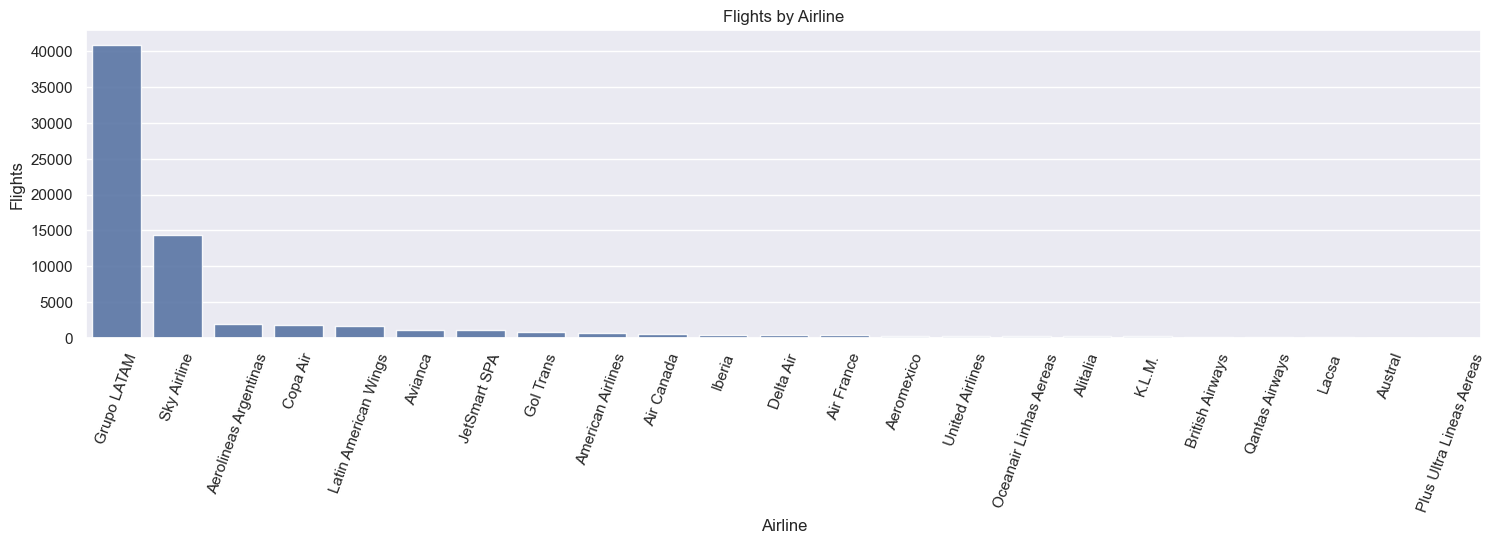

In [3]:
flights_by_airline = data['OPERA'].value_counts()
plt.figure(figsize=(18, 4))
sns.set_theme(style="darkgrid")
sns.barplot(x=flights_by_airline.index, y=flights_by_airline.values, alpha=0.9)
plt.title('Flights by Airline')
plt.ylabel('Flights', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.xticks(rotation=70)
plt.show()

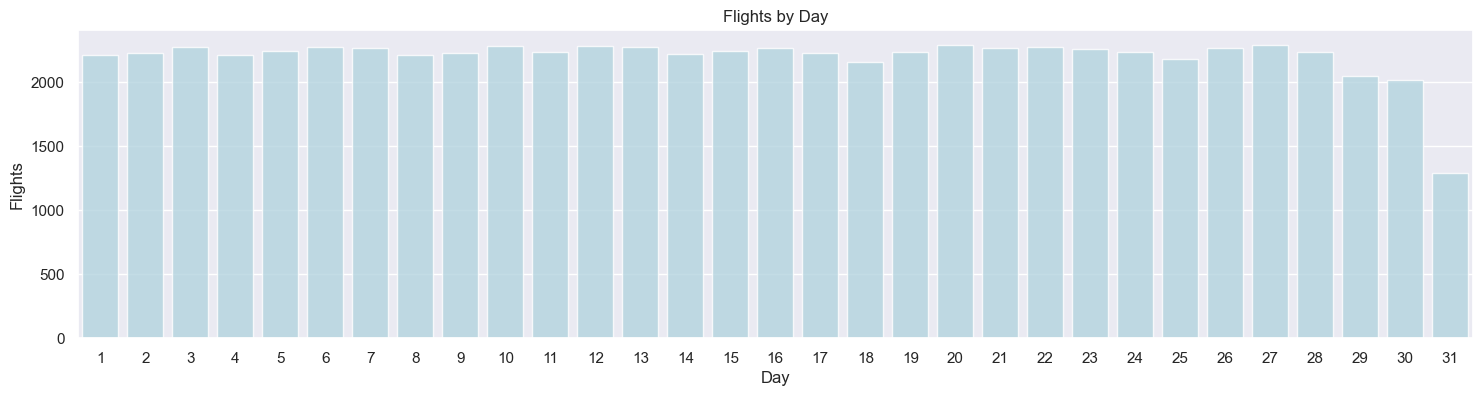

In [4]:
flights_by_day = data['DIA'].value_counts()
plt.figure(figsize=(18, 4))
sns.set_theme(style="darkgrid")
sns.barplot(x=flights_by_day.index, y=flights_by_day.values, color='lightblue', alpha=0.8)
plt.title('Flights by Day')
plt.ylabel('Flights', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.xticks(rotation=0)
plt.show()

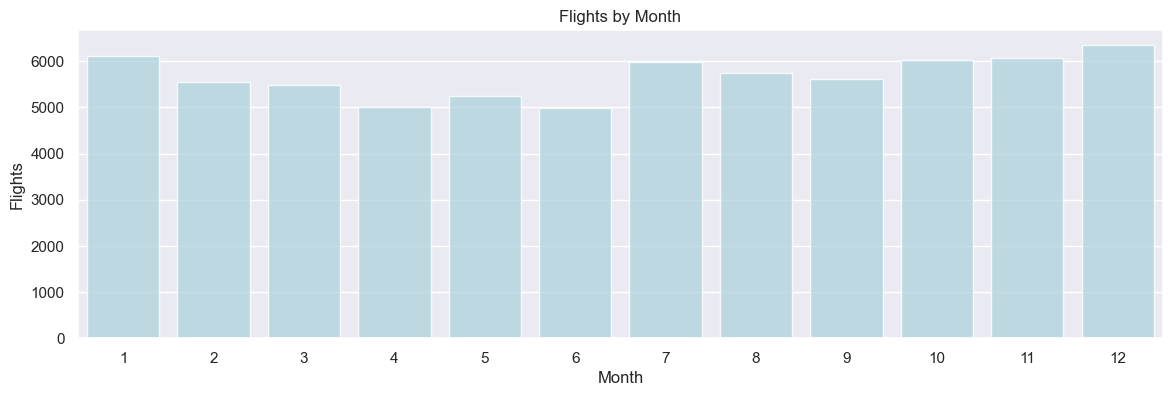

In [5]:
flights_by_month = data['MES'].value_counts()
plt.figure(figsize=(14, 4))
sns.set_theme(style="darkgrid")
sns.barplot(x=flights_by_month.index, y=flights_by_month.values, color='lightblue', alpha=0.8)
plt.title('Flights by Month')
plt.ylabel('Flights', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=0)
plt.show()

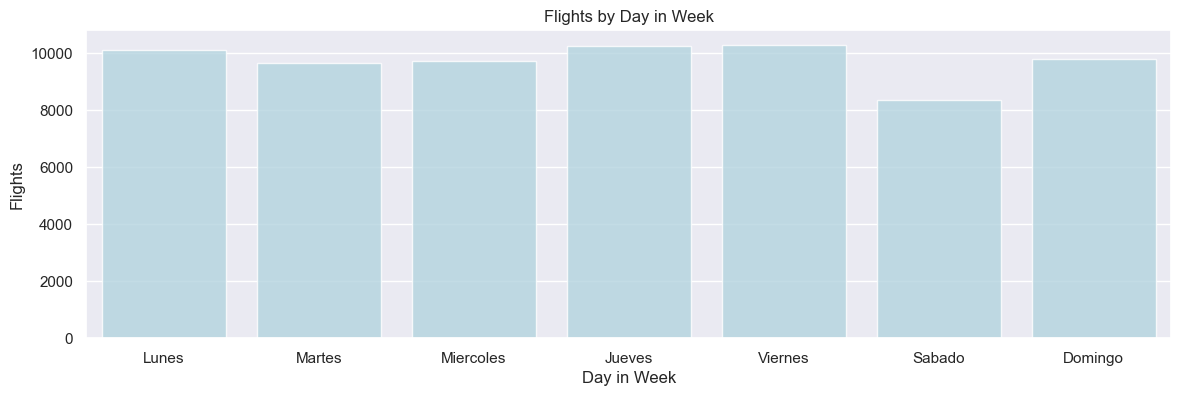

In [6]:
flights_by_day_in_week = data['DIANOM'].value_counts()
flights_by_day_in_week = flights_by_day_in_week.loc[["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]]

plt.figure(figsize=(14, 4))
sns.set_theme(style="darkgrid")
sns.barplot(x=flights_by_day_in_week.index, y=flights_by_day_in_week.values, color='lightblue', alpha=0.8)
plt.title('Flights by Day in Week')
plt.ylabel('Flights', fontsize=12)
plt.xlabel('Day in Week', fontsize=12)
plt.xticks(rotation=0)
plt.show()

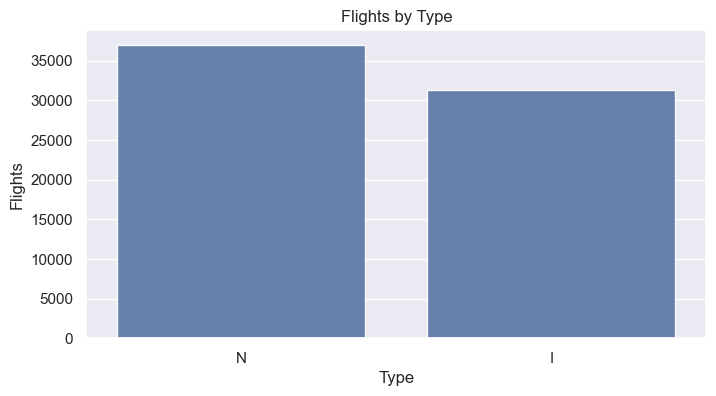

In [7]:
flights_by_type = data['TIPOVUELO'].value_counts()
sns.set_theme(style="darkgrid")
plt.figure(figsize=(8, 4))
sns.barplot(x=flights_by_type.index, y=flights_by_type.values, alpha=0.9)
plt.title('Flights by Type')
plt.ylabel('Flights', fontsize=12)
plt.xlabel('Type', fontsize=12)
plt.show()

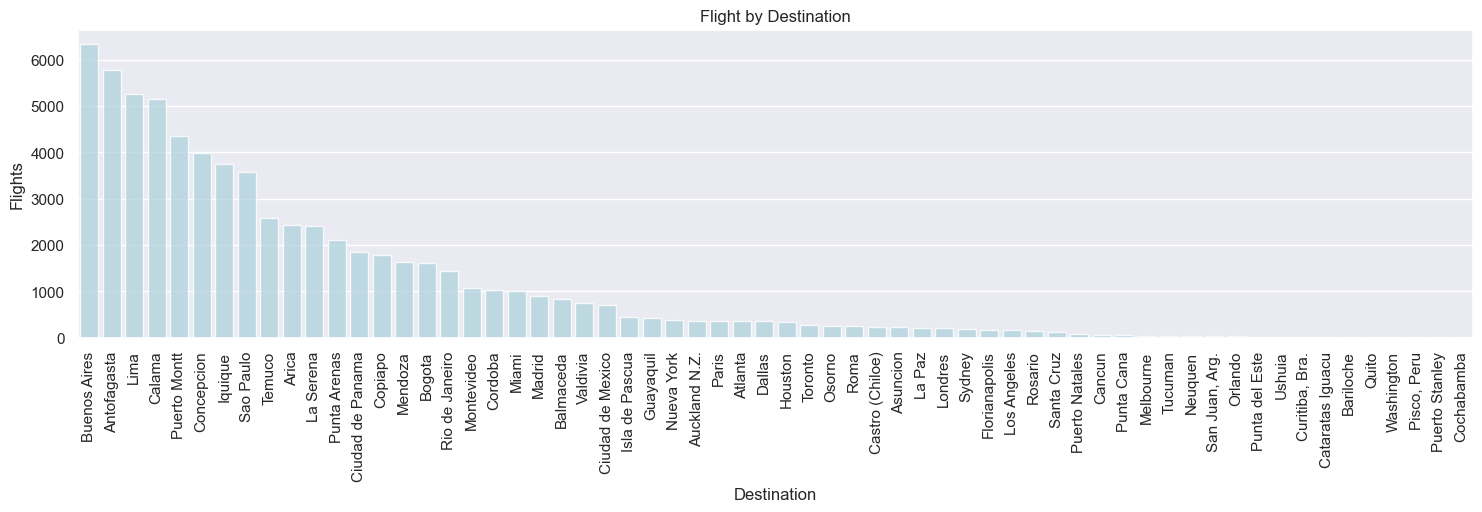

In [8]:
flight_by_destination = data['SIGLADES'].value_counts()
plt.figure(figsize=(18, 4))
sns.set_theme(style="darkgrid")
sns.barplot(x=flight_by_destination.index, y=flight_by_destination.values, color = 'lightblue', alpha=0.8)
plt.title('Flight by Destination')
plt.ylabel('Flights', fontsize=12)
plt.xlabel('Destination', fontsize=12)
plt.xticks(rotation=90)

plt.show()

## 2. Features Generation

In [9]:
from datetime import datetime

### 2.a. Period of Day

In [10]:
PERIOD_BORDERS = {
    "morning":   "05:00",  # "max": "11:59"
    "afternoon": "12:00",  # "max": "18:59"
    "evening":   "19:00",  # "max": "23:59"
    "night":     "00:00"   # "max": "04:59"
}
PERIOD_BORDERS = {
    k: datetime.strptime(v, '%H:%M').time()
    for k, v in PERIOD_BORDERS.items()
}

def get_period_day(date) -> str:
    date_time = datetime.strptime(date, '%Y-%m-%d %H:%M:%S').time()

    if date_time >= PERIOD_BORDERS["morning"] and date_time < PERIOD_BORDERS["afternoon"]:
        return "mañana"
    elif date_time >= PERIOD_BORDERS["afternoon"] and date_time < PERIOD_BORDERS["evening"]:
        return "tarde"
    else:
        return "noche"

In [11]:
data['period_day'] = data['Fecha-I'].apply(get_period_day)

### 2.b. High Season

In [12]:
from copy import deepcopy

In [13]:
HIGH_SEASON_RANGES = {
    "range1": {"min": "15-Dec", "max": "31-Dec"},
    "range2": {"min": "1-Jan",  "max":  "3-Mar"},
    "range3": {"min": "15-Jul", "max": "31-Jul"},
    "range4": {"min": "11-Sep", "max": "30-Sep"},
}
HIGH_SEASON_RANGES = {
    k1: {
        k2: datetime.strptime(v2, '%d-%b')
        for k2, v2 in v1.items()
    }
    for k1, v1 in HIGH_SEASON_RANGES.items()
}

def is_high_season(fecha: str) -> int:
    fecha_anio = int(fecha.split('-')[0])
    fecha = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')

    hsr = deepcopy(HIGH_SEASON_RANGES)
    hsr = {
        k1: {
            k2: v2.replace(year=fecha_anio)
            for k2, v2 in v1.items()
        }
        for k1, v1 in hsr.items()
    }

    cond = (
        (fecha >= hsr["range2"]["min"] and fecha <= hsr["range2"]["max"]) or
        (fecha >= hsr["range4"]["min"] and fecha <= hsr["range4"]["max"]) or
        (fecha >= hsr["range1"]["min"] and fecha <= hsr["range1"]["max"]) or
        (fecha >= hsr["range3"]["min"] and fecha <= hsr["range3"]["max"])
    )  # order based on number of days (for efficiency)
    if cond:
        return 1
    else:
        return 0

In [14]:
data['high_season'] = data['Fecha-I'].apply(is_high_season)

### 2.c. Difference in Minutes

In [15]:
def get_min_diff(data: pd.DataFrame) -> float:
    fecha_o = datetime.strptime(data["Fecha-O"], "%Y-%m-%d %H:%M:%S")
    fecha_i = datetime.strptime(data["Fecha-I"], "%Y-%m-%d %H:%M:%S")
    return ((fecha_o - fecha_i).total_seconds()) / 60.0

In [16]:
data['min_diff'] = data.apply(get_min_diff, axis=1)

### 2.d. Delay

In [17]:
threshold_in_minutes = 15
data['delay'] = np.array(data['min_diff'] > threshold_in_minutes, dtype=int)

In [18]:
data.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'period_day', 'high_season',
       'min_diff', 'delay'],
      dtype='object')

## 3. Data Analysis: Second Sight

### How is the delay rate across columns?

In [19]:
def get_rate_from_column(data: pd.DataFrame, column: str) -> pd.DataFrame:
    delays = {k: 0 for k in data[column].unique()}
    delayed_rows = data[column][data.delay == 1]
    delays.update(delayed_rows.value_counts().to_dict())
    del delayed_rows

    total = data[column].value_counts().to_dict()

    rates = {
        name: (
            round(total / delays[name], 2)
            if delays[name] > 0
            else 0
        )
        for name, total in total.items()
    }

    return pd.DataFrame.from_dict(
        rates,
        orient='index',
        columns=['Tasa (%)']
    )

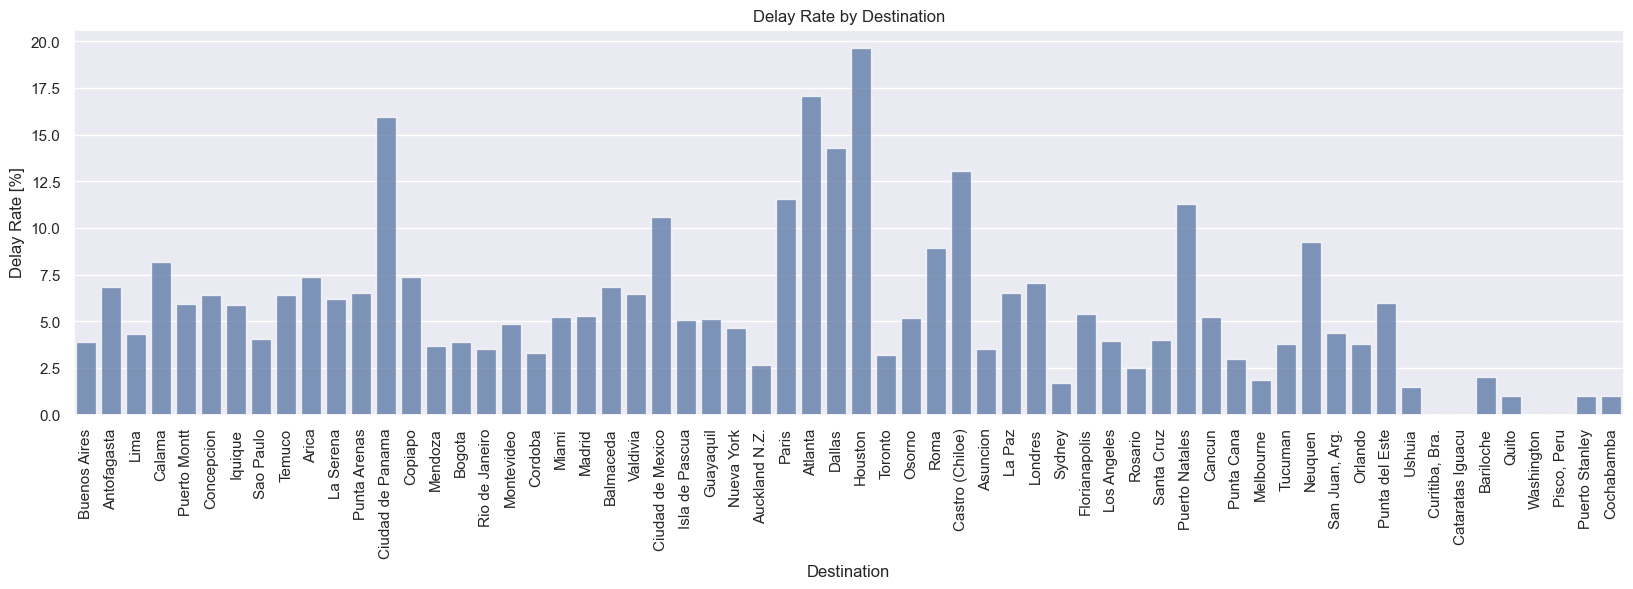

In [20]:
destination_rate = get_rate_from_column(data, 'SIGLADES')
destination_rate_values = data['SIGLADES'].value_counts().index

plt.figure(figsize=(20,5))
sns.set_theme(style="darkgrid")
sns.barplot(
    x=destination_rate_values,
    y=destination_rate.loc[destination_rate_values, 'Tasa (%)'],
    alpha=0.75
)
plt.title('Delay Rate by Destination')
plt.ylabel('Delay Rate [%]', fontsize=12)
plt.xlabel('Destination', fontsize=12)
plt.xticks(rotation=90)
plt.show()

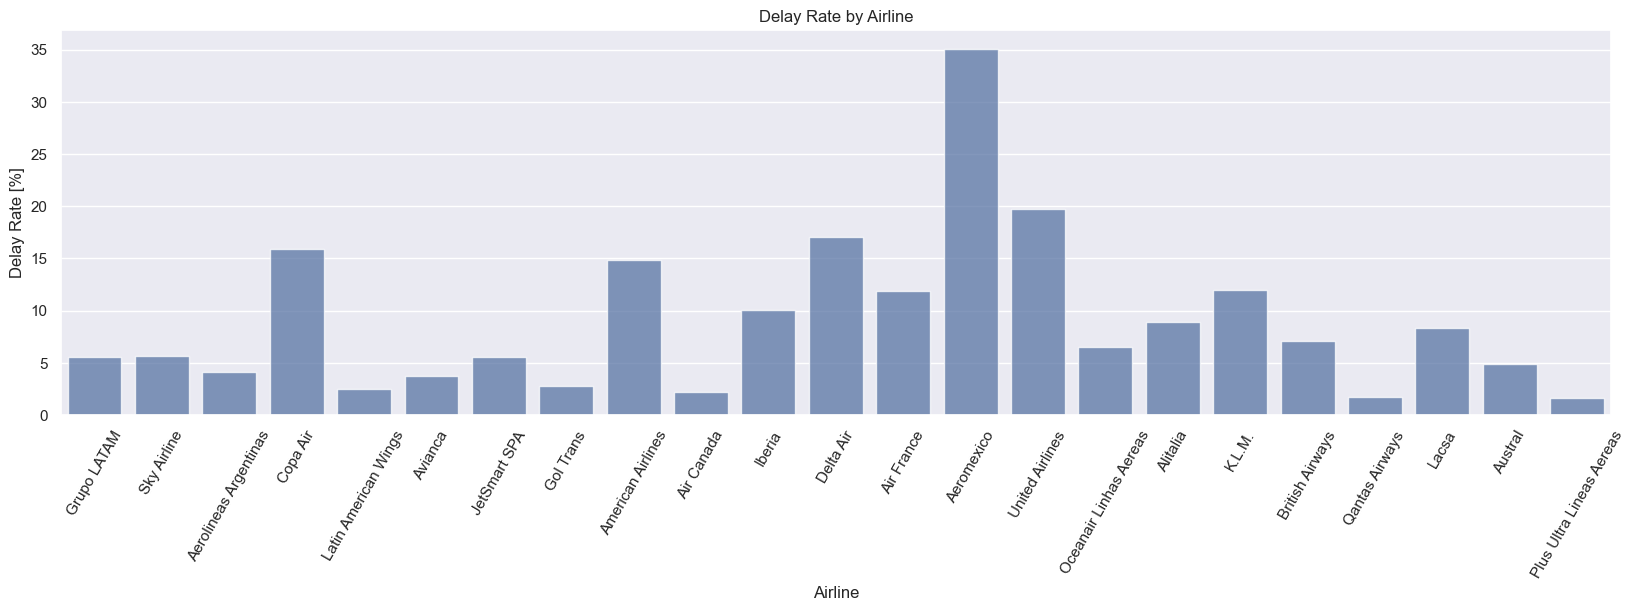

In [21]:
airlines_rate = get_rate_from_column(data, 'OPERA')
airlines_rate_values = data['OPERA'].value_counts().index

plt.figure(figsize=(20,5))
sns.set_theme(style="darkgrid")
sns.barplot(
    x=airlines_rate_values,
    y=airlines_rate.loc[airlines_rate_values, 'Tasa (%)'],
    alpha=0.75
)
plt.title('Delay Rate by Airline')
plt.ylabel('Delay Rate [%]', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.xticks(rotation=60)
plt.show()

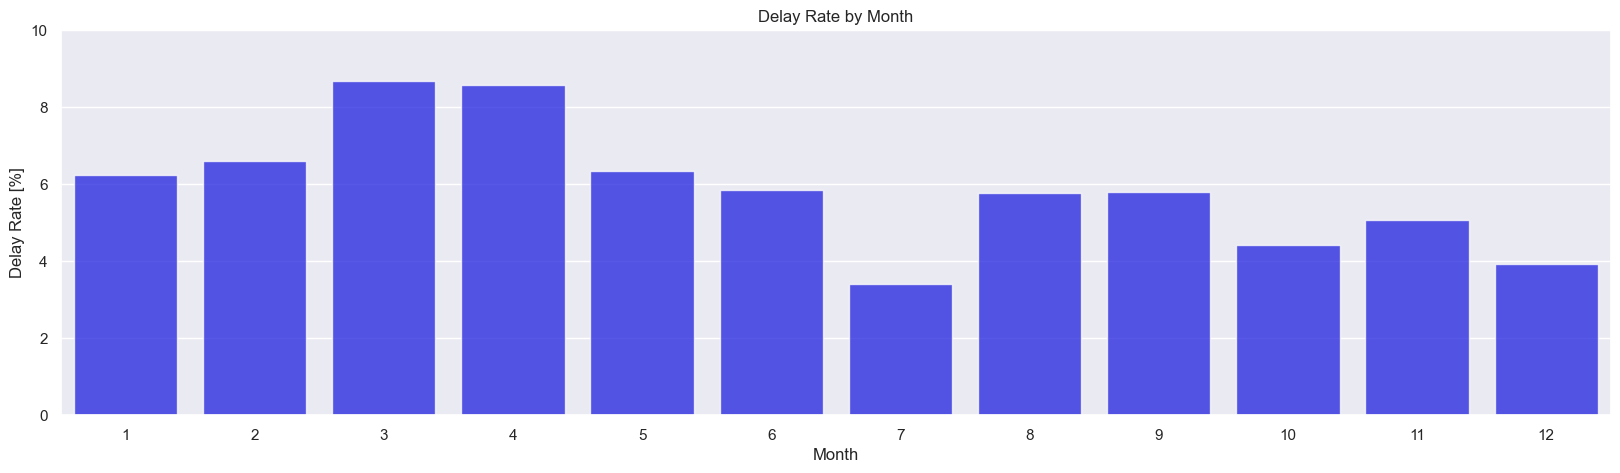

In [22]:
month_rate = get_rate_from_column(data, 'MES')
month_rate_value = [i for i in range(1, 13)]

plt.figure(figsize=(20,5))
sns.set_theme(style="darkgrid")
sns.barplot(
    x=month_rate_value,
    y=month_rate.loc[month_rate_value, 'Tasa (%)'],
    color='blue',
    alpha=0.75
)
plt.title('Delay Rate by Month')
plt.ylabel('Delay Rate [%]', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0,10)
plt.show()

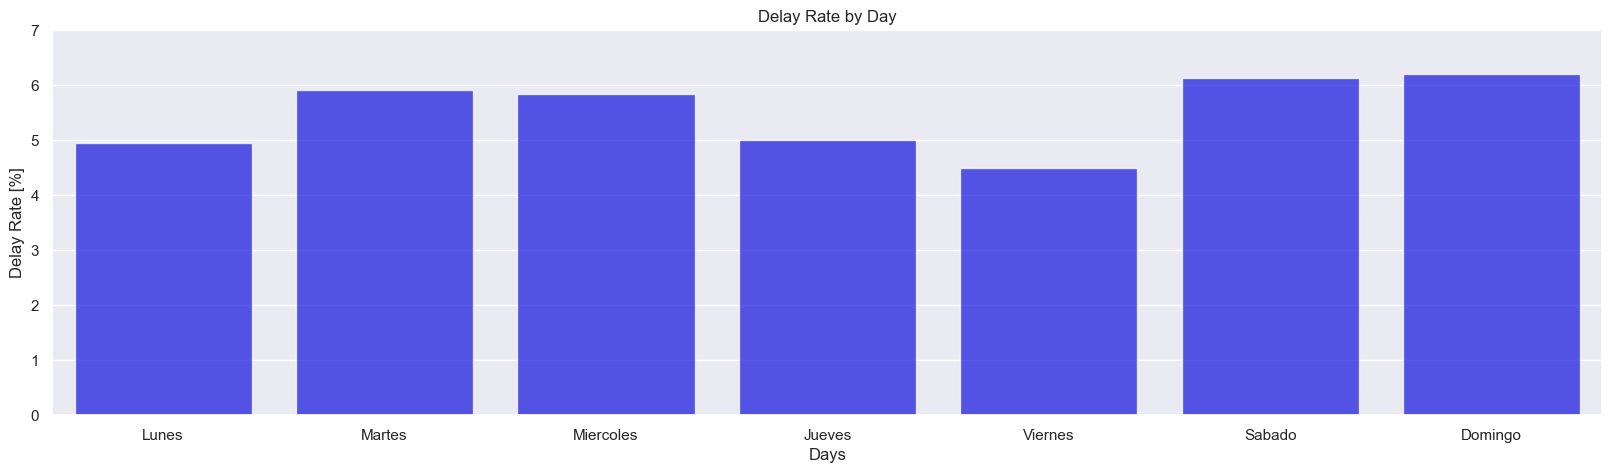

In [23]:
days_rate = get_rate_from_column(data, 'DIANOM')
days_rate_value = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

sns.set_theme(style="darkgrid")
plt.figure(figsize=(20, 5))
sns.barplot(
    x=days_rate_value,
    y=days_rate.loc[days_rate_value, 'Tasa (%)'],
    color='blue',
    alpha=0.75
)
plt.title('Delay Rate by Day')
plt.ylabel('Delay Rate [%]', fontsize=12)
plt.xlabel('Days', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0,7)
plt.show()

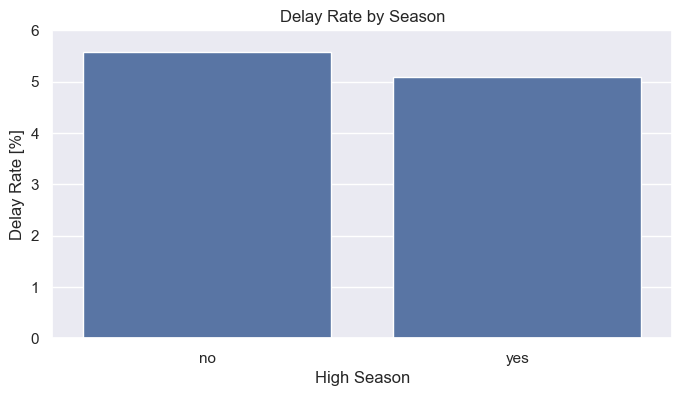

In [24]:
high_season_rate = get_rate_from_column(data, 'high_season')
high_season_rate_values = {0: "no", 1: "yes"}

plt.figure(figsize=(8, 4))
sns.set_theme(style="darkgrid")
sns.barplot(
    x=high_season_rate_values.values(),
    y=high_season_rate.loc[high_season_rate_values.keys(), 'Tasa (%)']
)
plt.title('Delay Rate by Season')
plt.ylabel('Delay Rate [%]', fontsize=12)
plt.xlabel('High Season', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0,6)
plt.show()

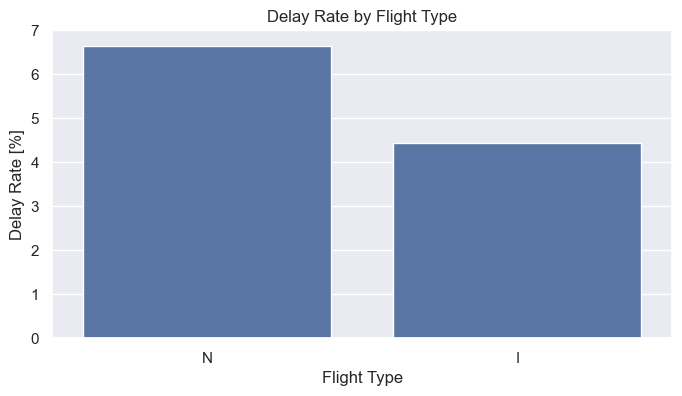

In [25]:
flight_type_rate = get_rate_from_column(data, 'TIPOVUELO')
flight_type_rate_values = data['TIPOVUELO'].value_counts().index

plt.figure(figsize=(8,4))
sns.set_theme(style="darkgrid")
sns.barplot(x=flight_type_rate_values, y=flight_type_rate.loc[flight_type_rate_values, 'Tasa (%)'])
plt.title('Delay Rate by Flight Type')
plt.ylabel('Delay Rate [%]', fontsize=12)
plt.xlabel('Flight Type', fontsize=12)
plt.ylim(0,7)
plt.show()

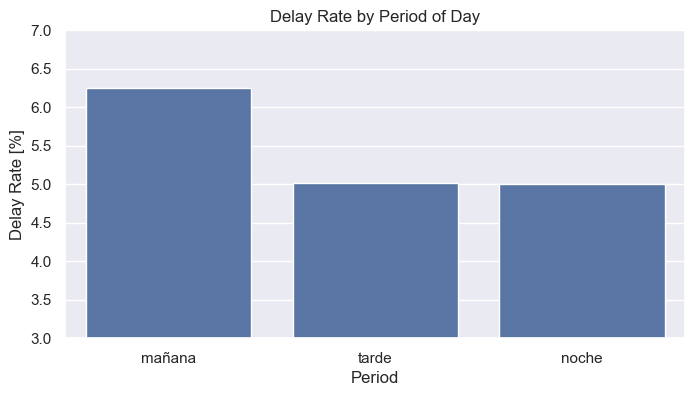

In [26]:
period_day_rate = get_rate_from_column(data, 'period_day')
period_day_rate_values = ["mañana", "tarde", "noche"]

plt.figure(figsize=(8, 4))
sns.set_theme(style="darkgrid")
sns.barplot(x=period_day_rate_values, y=period_day_rate.loc[period_day_rate_values, 'Tasa (%)'])
plt.title('Delay Rate by Period of Day')
plt.ylabel('Delay Rate [%]', fontsize=12)
plt.xlabel('Period', fontsize=12)
plt.ylim(3,7)
plt.show()

## 4. Training

### 4.a. Data Split (Training and Validation)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
training_data = shuffle(
    data[['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'delay']],
    random_state=111
)

In [29]:
# TODO: [MLE] So SIGLADES and DIANOM are not used? Why is training_data not used but features instead?
features = pd.concat(
    [
        pd.get_dummies(data['OPERA'],     prefix='OPERA'),
        pd.get_dummies(data['TIPOVUELO'], prefix='TIPOVUELO'),
        pd.get_dummies(data['MES'],       prefix='MES'),
    ],
    axis=1
)
target = data['delay']

In [30]:
features

,OPERA_Aerolineas Argentinas,OPERA_Aeromexico,OPERA_Air Canada,OPERA_Air France,OPERA_Alitalia,OPERA_American Airlines,OPERA_Austral,OPERA_Avianca,OPERA_British Airways,OPERA_Copa Air,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
target

0        0
1        0
2        0
3        0
4        0
        ..
68201    1
68202    1
68203    1
68204    0
68205    0
Name: delay, Length: 68206, dtype: int32

In [32]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

In [33]:
print(f"train shape: {x_train.shape} | test shape: {x_test.shape}")

train shape: (45698, 37) | test shape: (22508, 37)


In [34]:
y_train.value_counts('%')*100

0    81.618452
1    18.381548
Name: delay, dtype: float64

In [35]:
y_test.value_counts('%')*100

0    81.277768
1    18.722232
Name: delay, dtype: float64

### 4.b. Model Selection

#### 4.b.i. XGBoost

In [36]:
import xgboost as xgb
from xgboost import plot_importance

In [37]:
xgb_model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)

In [38]:
# Checking train
xgb_model.fit(x_train, y_train)
xgboost_y_preds_train = xgb_model.predict(x_train)
print(confusion_matrix(y_train, xgboost_y_preds_train))
print(classification_report(y_train, xgboost_y_preds_train))

[[37298     0]
 [ 8400     0]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     37298
           1       0.00      0.00      0.00      8400

    accuracy                           0.82     45698
   macro avg       0.41      0.50      0.45     45698
weighted avg       0.67      0.82      0.73     45698



In [39]:
# [MLE Note] Output is already boolean-like (it's int32 actually), so no need to use a threshold after using .predict()
xgboost_y_preds = xgb_model.predict(x_test)

In [40]:
confusion_matrix(y_test, xgboost_y_preds)

array([[18294,     0],
       [ 4214,     0]], dtype=int64)

In [41]:
print(classification_report(y_test, xgboost_y_preds))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.00      0.00      0.00      4214

    accuracy                           0.81     22508
   macro avg       0.41      0.50      0.45     22508
weighted avg       0.66      0.81      0.73     22508



#### 4.b.ii. Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
reg_model = LogisticRegression()

In [44]:
# Checking train
reg_model.fit(x_train, y_train)
reg_y_preds_train = reg_model.predict(x_train)
print(confusion_matrix(y_train, reg_y_preds_train))
print(classification_report(y_train, reg_y_preds_train))

[[37118   180]
 [ 8172   228]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     37298
           1       0.56      0.03      0.05      8400

    accuracy                           0.82     45698
   macro avg       0.69      0.51      0.48     45698
weighted avg       0.77      0.82      0.74     45698



In [45]:
reg_y_preds = reg_model.predict(x_test)

In [46]:
confusion_matrix(y_test, reg_y_preds)

array([[18193,   101],
       [ 4086,   128]], dtype=int64)

In [47]:
print(classification_report(y_test, reg_y_preds))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18294
           1       0.56      0.03      0.06      4214

    accuracy                           0.81     22508
   macro avg       0.69      0.51      0.48     22508
weighted avg       0.77      0.81      0.74     22508



## 5. Data Analysis: Third Sight

### Feature Importance

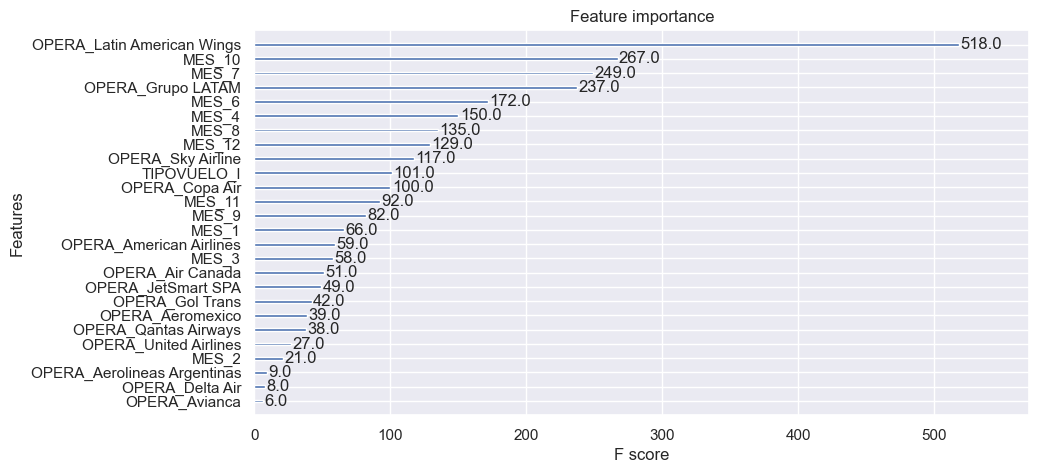

In [48]:
fig, ax = plt.subplots(figsize=(10,5))
plot_importance(xgb_model, ax=ax)
plt.show()

In [49]:
top_10_features = [
    "OPERA_Latin American Wings", 
    "MES_7",
    "MES_10",
    "OPERA_Grupo LATAM",
    "MES_12",
    "TIPOVUELO_I",
    "MES_4",
    "MES_11",
    "OPERA_Sky Airline",
    "OPERA_Copa Air"
]

### Data Balance

In [50]:
y_train_is_true = y_train == 1
n_y1 = y_train_is_true.sum()
n_y0 = y_train.shape[0] - n_y1
scale = n_y0 / n_y1
print("n_y0:", n_y0)
print("n_y1:", n_y1)
print("scale:", scale)

n_y0: 37298
n_y1: 8400
scale: 4.4402380952380955


## 6. Training with Improvement

### 6.a. Data Split

In [51]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(
    features[top_10_features],
    target,
    test_size=0.33,
    random_state=42
)

### 6.b. Model Selection

#### 6.b.i. XGBoost with Feature Importance and with Balance

In [52]:
xgb_model_2 = xgb.XGBClassifier(random_state=1, learning_rate=0.01, scale_pos_weight=scale)

In [53]:
# Checking train
xgb_model_2.fit(x_train2, y_train2)
xgboost_y_preds_2_train = xgb_model_2.predict(x_train2)
print(confusion_matrix(y_train2, xgboost_y_preds_2_train))
print(classification_report(y_train2, xgboost_y_preds_2_train))

[[19429 17869]
 [ 2695  5705]]
              precision    recall  f1-score   support

           0       0.88      0.52      0.65     37298
           1       0.24      0.68      0.36      8400

    accuracy                           0.55     45698
   macro avg       0.56      0.60      0.51     45698
weighted avg       0.76      0.55      0.60     45698



In [54]:
xgboost_y_preds_2 = xgb_model_2.predict(x_test2)

In [55]:
confusion_matrix(y_test2, xgboost_y_preds_2)

array([[9556, 8738],
       [1313, 2901]], dtype=int64)

In [56]:
print(classification_report(y_test2, xgboost_y_preds_2))

              precision    recall  f1-score   support

           0       0.88      0.52      0.66     18294
           1       0.25      0.69      0.37      4214

    accuracy                           0.55     22508
   macro avg       0.56      0.61      0.51     22508
weighted avg       0.76      0.55      0.60     22508



#### 6.b.ii. XGBoost with Feature Importance but without Balance

In [57]:
xgb_model_3 = xgb.XGBClassifier(random_state=1, learning_rate=0.01)

In [58]:
# Checking train
xgb_model_3.fit(x_train2, y_train2)
xgboost_y_preds_3_train = xgb_model_3.predict(x_train2)
print(confusion_matrix(y_train2, xgboost_y_preds_3_train))
print(classification_report(y_train2, xgboost_y_preds_3_train))

[[37281    17]
 [ 8353    47]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     37298
           1       0.73      0.01      0.01      8400

    accuracy                           0.82     45698
   macro avg       0.78      0.50      0.46     45698
weighted avg       0.80      0.82      0.74     45698



In [59]:
xgboost_y_preds_3 = xgb_model_3.predict(x_test2)

In [60]:
confusion_matrix(y_test2, xgboost_y_preds_3)

array([[18286,     8],
       [ 4188,    26]], dtype=int64)

In [61]:
print(classification_report(y_test2, xgboost_y_preds_3))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.76      0.01      0.01      4214

    accuracy                           0.81     22508
   macro avg       0.79      0.50      0.45     22508
weighted avg       0.80      0.81      0.73     22508



#### 6.b.iii. Logistic Regression with Feature Importante and with Balance

In [62]:
class_weight_reg_2 = {1: n_y0/len(y_train), 0: n_y1/len(y_train)}
class_weight_reg_2

{1: 0.8161845157337302, 0: 0.18381548426626987}

In [63]:
reg_model_2 = LogisticRegression(class_weight=class_weight_reg_2)
reg_model_2

LogisticRegression(class_weight={0: 0.18381548426626987, 1: 0.8161845157337302})

In [64]:
# Checking train
reg_model_2.fit(x_train2, y_train2)
reg_y_preds_2_train = reg_model_2.predict(x_train2)
print(confusion_matrix(y_train2, reg_y_preds_2_train))
print(classification_report(y_train2, reg_y_preds_2_train))

[[19250 18048]
 [ 2730  5670]]
              precision    recall  f1-score   support

           0       0.88      0.52      0.65     37298
           1       0.24      0.68      0.35      8400

    accuracy                           0.55     45698
   macro avg       0.56      0.60      0.50     45698
weighted avg       0.76      0.55      0.59     45698



In [65]:
reg_y_preds_2 = reg_model_2.predict(x_test2)

In [66]:
confusion_matrix(y_test2, reg_y_preds_2)

array([[9487, 8807],
       [1314, 2900]], dtype=int64)

In [67]:
print(classification_report(y_test2, reg_y_preds_2))

              precision    recall  f1-score   support

           0       0.88      0.52      0.65     18294
           1       0.25      0.69      0.36      4214

    accuracy                           0.55     22508
   macro avg       0.56      0.60      0.51     22508
weighted avg       0.76      0.55      0.60     22508



#### 6.b.iv. Logistic Regression with Feature Importante but without Balance

In [68]:
reg_model_3 = LogisticRegression()
reg_model_3

LogisticRegression()

In [69]:
# Checking train
reg_model_3.fit(x_train2, y_train2)
reg_y_preds_3_train = reg_model_3.predict(x_train2)
print(confusion_matrix(y_train2, reg_y_preds_3_train))
print(classification_report(y_train2, reg_y_preds_3_train))

[[37204    94]
 [ 8285   115]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     37298
           1       0.55      0.01      0.03      8400

    accuracy                           0.82     45698
   macro avg       0.68      0.51      0.46     45698
weighted avg       0.77      0.82      0.74     45698



In [70]:
reg_y_preds_3 = reg_model_3.predict(x_test2)

In [71]:
confusion_matrix(y_test2, reg_y_preds_3)

array([[18246,    48],
       [ 4160,    54]], dtype=int64)

In [72]:
print(classification_report(y_test2, reg_y_preds_3))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.53      0.01      0.03      4214

    accuracy                           0.81     22508
   macro avg       0.67      0.51      0.46     22508
weighted avg       0.76      0.81      0.73     22508



## 7. Data Science Conclusions

By looking at the results of the 6 trained models, it can be determined:
- There is no noticeable difference in results between XGBoost and LogisticRegression.
- Does not decrease the performance of the model by reducing the features to the 10 most important.
- Improves the model's performance when balancing classes, since it increases the recall of class "1".

**With this, the model to be productive must be the one that is trained with the top 10 features and class balancing, but which one?**

## 8. [MLE] Model candidates

In [80]:
from math import isclose

In [87]:
def get_model_metrics(y_train, y_preds) -> dict:
    metrics = {}
    metrics["tn"], metrics["fp"], metrics["fn"], metrics["tp"] = confusion_matrix(
        y_true=y_train,
        y_pred=y_preds
    ).ravel()
    metrics["total"] = metrics["tn"] + metrics["fp"] + metrics["fn"] + metrics["tp"]

    metrics["accuracy"] = (metrics["tp"] + metrics["tn"]) / metrics["total"]

    preds = metrics["tp"] + metrics["fp"]
    true_pos = metrics["tp"] + metrics["fn"]

    if preds != 0:
        metrics["precision"] = metrics["tp"] / preds
    else:
        metrics["precision"] = 0.0

    if true_pos != 0:
        metrics["recall"] = metrics["tp"] / true_pos
    else:
        metrics["recall"] = 0.0

    if (metrics["precision"] > 0.0) and (metrics["recall"] > 0.0):
        metrics["f1_score"] = 2 * (metrics["precision"] * metrics["recall"]) / (metrics["precision"] + metrics["recall"])
    else:
        metrics["f1_score"] = 0.0

    return metrics

In [113]:
xgb_metrics_train = get_model_metrics(y_train2, y_preds=xgboost_y_preds_2_train)
reg_metrics_train = get_model_metrics(y_train2, y_preds=reg_y_preds_2_train)

xgb_metrics_test = get_model_metrics(y_test2, y_preds=xgboost_y_preds_2)
reg_metrics_test = get_model_metrics(y_test2, y_preds=reg_y_preds_2)

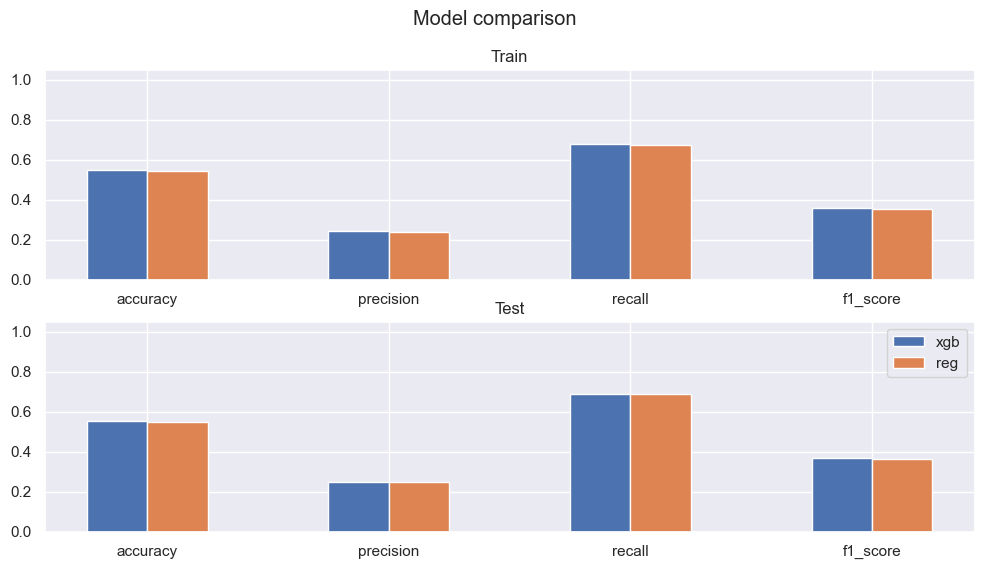

In [120]:
metric_set = {"accuracy", "precision", "recall", "f1_score"}

metrics_dict = {
    "plot_data_xgb": {
        "train": {k: v for k, v in xgb_metrics_train.items() if k in metric_set},
        "test": {k: v for k, v in xgb_metrics_test.items() if k in metric_set}
    },
    "plot_data_reg": {
        "train": {k: v for k, v in reg_metrics_train.items() if k in metric_set},
        "test": {k: v for k, v in reg_metrics_test.items() if k in metric_set}
    },
}
total_metrics = len(metrics_dict["plot_data_xgb"]["train"])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
plt.suptitle("Model comparison")
axes = {"train": ax1, "test": ax2}

axes["train"].set_title("Train")
axes["test"].set_title("Test")

for sel_split in ["train", "test"]:
    axes[sel_split].bar(
        range(total_metrics),
        metrics_dict["plot_data_xgb"][sel_split].values(),
        width=0.25
    )
    axes[sel_split].bar(
        [i + 0.25 for i in range(total_metrics)],
        metrics_dict["plot_data_reg"][sel_split].values(),
        width=0.25
    )

    axes[sel_split].set_xticks([i + 0.125 for i in range(total_metrics)])
    axes[sel_split].set_xticklabels(metrics_dict["plot_data_xgb"][sel_split].keys())
    axes[sel_split].set_ylim(0.0, 1.05)

plt.legend(["xgb", "reg"])
plt.show()

[MLE] Indeed both models are pretty similar. When prompted I'd choose XGBoost as I believe it'll render better results in production, but it'd be best if later on we do more feature engineering, cross-validation and hyperparameter tuning.